# Imports

In [92]:
import pandas as pd
from IPython.display import IFrame
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
# import lda
# import nltk
# from nltk.corpus import words
# from nltk.metrics.distance import jaccard_distance, edit_distance
# from nltk.util import ngrams
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb


# nltk.download('words')
pd.set_option('display.max_columns', None)

# Assignment Overview

In [2]:
IFrame("./references/README.pdf", width=900, height=600)

# Dictionary

### Demographics table:
this table contains contextual information about a sample of gemini users.
the target class we are trying to predict is LEVEL

* EXCHANGE_ACCOUNT_ID - unique identifier for a person
* level - the target class we are trying to predict
* CREATED_AT - date the account was created
* FIRST_VERIFIED_AT - date the account was verified
* STATE_CODE - two letter state that the user of the account resides in
* COUNTRY_CODE - two letter country code the user resides in
* BIRTH_YEAR - year the user of the account was born
* OCCUPATION - stated occupation of the user
* BROWSER_COUNT - number of distinct browsers user has used
* OS_COUNT - number of distinct operating systems detected
* TOTAL_DEVICES - total count of distinct devices used by the account
* SESSION_COUNT - count of sessions initiated by the user
* COUNT_BANKS - count of bank accounts attached to user

### Exposure table:
this table contains aggregated information about the source and destination of user's transfers

* EXCHANGE_ACCOUNT_ID - unique identifier for a person
* SENT_INDIRECT_EXPOSURE - total outgoing volume (multiple hops before arriving at destination) to specified cluster
* SENT_DIRECT_EXPOSURE - direct direct send volume to specified cluster
* RECEIVED_INDIRECT_EXPOSURE - total incoming volume (multiple hops before arriving at Gemini) from specified cluster
* RECEIVED_DIRECT_EXPOSURE - total receiving volume (direct receive) from specified cluster
* cluster_category - type of service (ie exchange, merchant, private wallet etc)
* cluster_name - name of the service

### Transfers table:
this table contains a sample of transfer logs in 2020

* ACCOUNT_ID - unique identifier for a person
* TX_TIME - timestamp of a transfer
* AMOUNT - quantity transfered
* currency - currency of the transfer
* tx_type - type of the transfer (deposit/withdrawal/etc)

# EDA

In [3]:
def eda(df):
    """Print exploratory statistics about given dataframe."""
    
    print('Shape:')
    print(df.shape)
    print('-----------------------------')
    print('Sample:')
    print(df.head(3).append(df.tail(3)))
    print('-----------------------------')
    print('Describe:')
    print(df.describe(include='all'))
    print('-----------------------------')
    print('Percent missing values:')
    print(df.isnull().sum() / df.shape[0] * 100.00)
    print('-----------------------------')
    print('Data types:')
    print(df.dtypes)
    
    return None

In [4]:
def clean_text_columns(df, col_list=None):
    """Basic text cleaning."""
    
    # use object columns if none provided
    if col_list is None:
        col_list = df.loc[:, df.dtypes == object].columns
        
    # get rid of non letter characters
    df[col_list] = df[col_list].apply(lambda x: x.str.replace('[^a-zA-Z ]', ''))    
    # convert to all uppercase
    df[col_list] = df[col_list].apply(lambda x: x.astype(str).str.upper())
    # strip whitespace
    df[col_list] = df[col_list].apply(lambda x: x.str.strip())
    
    return df

In [5]:
def autocorrect(myword):
    """Correct mispelled words using levanstine distance."""
    
    correct_spellings = words.words()
    distance_dict = {}
    for word in correct_spellings:
        ed = nltk.edit_distance(myword, word)
        distance_dict[word] = ed
        if ed == 0:
            break

    return(min(distance_dict, key=distance_dict.get))

In [6]:
def group_occupation(occupation, other=None):
    """Narrow down occupations."""

    tech_keywords = ['ENGINEER', 'IT', 'SOFTWARE', 'TECHNOLOGY', 'DATA', 'DEVELOPER', 'PROGRAMMER', 'TECH', 'WEB', 'COMPUTER', 'DBA', 'SCIENTIST']
    law_keywords = ['LAWYER', 'ATTORNEY']
    medicine_keywords = ['PHYSICIAN', 'DOCTOR', 'SURGEON', 'DENTIST', 'PHARMACIST', 'MD', 'NURSE', 'RN', 'NURSING']
    self_keywords = ['SELF']
    sales_keywords = ['SALES']
    retired_keywords = ['RETIRED', 'RETIREE', 'RETIRE']
    student_keywords = ['STUDENT']
    executive_keywords = ['CEO', 'CTO', 'COO', 'CPO', 'CFO', 'CIO', 'DIRECTOR', 'FOUNDER', 'PRESIDENT', 'EXECUTIVE', 'OWNER', 'VP']
    unemployed_keywords = ['UNEMPLOYED', 'NONE']
    finance_keywords = ['FINANCE', 'ACCOUNTANT', 'WEALTH', 'BANKER', 'BANK', 'FINANCIAL', 'CPA', 'ACCOUNTING']
    manager_keywords = ['MANAGER', 'MANAGEMENT', 'SUPERVISOR']
    real_estate_keywords = ['REAL ESTATE', 'REALTOR', 'BROKER']
    business_keywords = ['BUSINESS', 'BUSINESSMAN']

    if other is not None:
        if occupation in other:
            return 'OTHER'
        else:
            return occupation
    else:
        if any(word in occupation for word in tech_keywords):
            return 'TECH'
        elif any(word in occupation for word in law_keywords):
            return 'LAW'
        elif any(word in occupation for word in medicine_keywords):
            return 'MEDICINE'    
        elif any(word in occupation for word in self_keywords):
            return 'SELF'
        elif any(word in occupation for word in sales_keywords):
            return 'SALES'   
        elif any(word in occupation for word in retired_keywords):
            return 'RETIRED'   
        elif any(word in occupation for word in student_keywords):
            return 'STUDENT'  
        elif any(word in occupation for word in executive_keywords):
            return 'EXECUTIVE'  
        elif any(word in occupation for word in finance_keywords):
            return 'FINANCE'  
        elif any(word in occupation for word in real_estate_keywords):
            return 'REAL ESTATE' 
        elif any(word in occupation for word in manager_keywords):
            return 'MANAGER'  
        elif any(word in occupation for word in business_keywords):
            return 'BUSINESS'  
        elif any(word in occupation for word in unemployed_keywords):
            return 'UNEMPLOYED'  
        elif occupation is None:
            return 'MISSING'
        else:
            return occupation

In [7]:
data_dir = '../data/raw/'

### Demographics

In [8]:
dem = pd.read_csv(data_dir + 'demographics_train.csv')

In [9]:
eda(dem)

Shape:
(8241, 13)
-----------------------------
Sample:
      EXCHANGE_ACCOUNT_ID    level    CREATED_AT FIRST_VERIFIED_AT STATE_CODE  \
0                       1  level_a        1/0/00     12/14/16 0:00        NaN   
1                       3  level_a        1/0/00      4/10/17 0:00        NaN   
2                       5  level_a        1/0/00       5/2/17 0:00        NaN   
8238                21663  level_b  10/5/15 0:00      10/5/15 0:00         NY   
8239                21665  level_b   6/4/19 0:00       6/4/19 0:00         CA   
8240                21667  level_b  9/17/19 0:00      9/16/19 0:00         GA   

     COUNTRY_CODE  BIRTH_YEAR OCCUPATION  BROWSER_COUNT  OS_COUNT  \
0             NaN         NaN        NaN            NaN       NaN   
1             NaN         NaN        NaN            NaN       NaN   
2             NaN         NaN        NaN            NaN       NaN   
8238           us      1982.0    finance            1.0       1.0   
8239           us      1984.0  

In [10]:
dem = clean_text_columns(dem, col_list=['STATE_CODE', 'COUNTRY_CODE', 'OCCUPATION'])

In [11]:
# convert to datetime
dem['CREATED_AT'] =  pd.to_datetime(dem['CREATED_AT'], errors='coerce')
dem['FIRST_VERIFIED_AT'] =  pd.to_datetime(dem['FIRST_VERIFIED_AT'], errors='coerce')

In [12]:
# autocorrect mispelled words
# dem['OCCUPATION0'] = dem['OCCUPATION'].apply(autocorrect)
# dem.OCCUPATION0.value_counts()

In [13]:
# dem[dem['OCCUPATION'] != dem['OCCUPATION0']]

In [14]:
dem.head(2).append(dem.tail(2))

,EXCHANGE_ACCOUNT_ID,level,CREATED_AT,FIRST_VERIFIED_AT,STATE_CODE,COUNTRY_CODE,BIRTH_YEAR,OCCUPATION,BROWSER_COUNT,OS_COUNT,TOTAL_DEVICES,SESSION_COUNT,COUNT_BANKS
0,1,level_a,NaT,2016-12-14,NAN,NAN,NaN,NAN,NaN,NaN,NaN,1,6.0
1,3,level_a,NaT,2017-04-10,NAN,NAN,NaN,NAN,NaN,NaN,NaN,1,4.0
8239,21665,level_b,2019-06-04,2019-06-04,CA,US,1984.0,NAN,3.0,1.0,5.0,134,1.0
8240,21667,level_b,2019-09-17,2019-09-16,GA,US,1977.0,NAN,4.0,2.0,7.0,80,20.0


In [15]:
# # create term-document matrix
# countvec = CountVectorizer()
# X = countvec.fit_transform(dem.OCCUPATION)

# # fit LDA model
# model = lda.LDA(n_topics=20, n_iter=1500, random_state=1)
# model.fit(X)

In [16]:
# topic_word = model.topic_word_ 
# n_top_words = 8
# for i, topic_dist in enumerate(topic_word):
#     topic_words = np.array(vocab)[np.argsort(topic_dist)][:-n_top_words:-1]
#     print('Topic {}: {}'.format(i, ' '.join(topic_words)))

In [17]:
# topic_word

In [18]:
# X = lda.datasets.load_reuters()
# vocab = lda.datasets.load_reuters_vocab()
# titles = lda.datasets.load_reuters_titles()

In [19]:
# apply occupation grouping based on keywords
dem['OCCUPATION1'] = dem['OCCUPATION'].apply(group_occupation)
dem.OCCUPATION1.value_counts()

TECH                   1669
NAN                    1113
EXECUTIVE               697
SELF                    482
FINANCE                 386
                       ... 
HOME PERSON               1
PA                        1
OIL AND GAS LANDMAN       1
COMEDIAN                  1
ENTREPRENUR               1
Name: OCCUPATION1, Length: 807, dtype: int64

In [20]:
# Group occupations that show up less than 10 times as 'OTHER'
dem['dummy'] = 1
occs = dem.groupby('OCCUPATION1').agg({'dummy':sum}).reset_index()
other_keywords = occs[occs['dummy'] < 10].OCCUPATION1.unique()
dem['OCCUPATION2'] = dem['OCCUPATION1'].apply(group_occupation, other=other_keywords)

In [21]:
# new occupation grouping
dem.OCCUPATION2.value_counts()

TECH            1669
OTHER           1179
NAN             1113
EXECUTIVE        697
SELF             482
FINANCE          386
MANAGER          381
MEDICINE         281
STUDENT          278
SALES            230
RETIRED          208
CONSULTANT       174
INVESTOR         156
REAL ESTATE      147
LAW              139
TRADER           118
ENTREPRENEUR     104
BUSINESS          86
MARKETING         75
ANALYST           56
UNEMPLOYED        49
TEACHER           35
DESIGNER          22
PILOT             21
PROFESSOR         19
ARTIST            19
RESEARCHER        19
DRIVER            18
CONSTRUCTION      14
PHOTOGRAPHER      12
CONSULTING        11
POKER PLAYER      11
INSURANCE         11
MUSICIAN          11
BARTENDER         10
Name: OCCUPATION2, dtype: int64

In [22]:
# impute state code based on country code
dem.loc[(dem['STATE_CODE'] == 'NAN') & (dem['COUNTRY_CODE'] != 'NAN') & (dem['COUNTRY_CODE'] != 'US'), 'STATE_CODE'] = 'OTHER'

In [23]:
dem.COUNTRY_CODE.value_counts()

US     7113
SG      413
CA      238
HK      199
GB      121
NAN      44
KR       38
IL       12
AU        7
PL        7
FR        6
KY        5
BR        5
JP        4
MU        3
PH        3
MX        3
VG        2
TH        2
VC        2
CN        2
CH        1
ID        1
PR        1
ZA        1
CW        1
LB        1
TR        1
BS        1
EE        1
BE        1
IS        1
IE        1
Name: COUNTRY_CODE, dtype: int64

In [24]:
dem.STATE_CODE.value_counts()

CA                  1603
NY                  1000
FL                   699
OTHER                662
TX                   529
                    ... 
AK                     1
BRUXELLES              1
HI                     1
BRGY SAN ANTONIO       1
TAIPEI                 1
Name: STATE_CODE, Length: 125, dtype: int64

### Exposure

In [25]:
exp = pd.read_csv(data_dir + 'exposure_train.csv')

In [26]:
eda(exp)

Shape:
(45700, 7)
-----------------------------
Sample:
       EXCHANGE_ACCOUNT_ID  SENT_INDIRECT_EXPOSURE  SENT_DIRECT_EXPOSURE  \
0                    15755                    7.61                   0.0   
1                    10761                   57.97                   0.0   
2                    15755                   14.04                   0.0   
45697                 6587                 -163.35                   0.0   
45698                 6587                    0.00                   0.0   
45699                10819                    0.00                   0.0   

       RECEIVED_INDIRECT_EXPOSURE  RECEIVED_DIRECT_EXPOSURE cluster_category  \
0                         1765.90                       0.0       category_1   
1                           38.47                       0.0       category_2   
2                            0.00                       0.0       category_1   
45697                      -13.98                       0.0      category_11   
45698      

In [27]:
exp.head()

,EXCHANGE_ACCOUNT_ID,SENT_INDIRECT_EXPOSURE,SENT_DIRECT_EXPOSURE,RECEIVED_INDIRECT_EXPOSURE,RECEIVED_DIRECT_EXPOSURE,cluster_category,cluster_name
0,15755,7.61,0.0,1765.90,0.0,category_1,service_1
1,10761,57.97,0.0,38.47,0.0,category_2,service_3
2,15755,14.04,0.0,0.00,0.0,category_1,service_4
3,8617,5.39,0.0,0.00,0.0,category_2,service_3
4,15755,6089.46,0.0,725.21,0.0,category_1,service_7


In [28]:
# multiple rows per person <- will need to aggregate
exp['dummy'] = 1
exp.groupby('EXCHANGE_ACCOUNT_ID').agg({'dummy':'sum'}).sort_values(by='dummy', ascending=False)

,dummy
EXCHANGE_ACCOUNT_ID,
6137,424
16541,417
17459,403
15489,343
21631,323
...,...
11631,1
13245,1
9443,1


In [29]:
# look at example
exp[exp['EXCHANGE_ACCOUNT_ID'] == 17831]

,EXCHANGE_ACCOUNT_ID,SENT_INDIRECT_EXPOSURE,SENT_DIRECT_EXPOSURE,RECEIVED_INDIRECT_EXPOSURE,RECEIVED_DIRECT_EXPOSURE,cluster_category,cluster_name,dummy
27413,17831,11796.06,11796.06,0.0,0.0,category_6,service_18,1
27651,17831,298190.31,298190.31,0.0,0.0,category_1,service_50,1


In [30]:
# create dummy variables for cluster_category
exp = exp.merge(pd.get_dummies(exp[['cluster_category']]), left_index=True, right_index=True)
exp.head()

,EXCHANGE_ACCOUNT_ID,SENT_INDIRECT_EXPOSURE,SENT_DIRECT_EXPOSURE,RECEIVED_INDIRECT_EXPOSURE,RECEIVED_DIRECT_EXPOSURE,cluster_category,cluster_name,dummy,cluster_category_category_1,cluster_category_category_10,cluster_category_category_11,cluster_category_category_12,cluster_category_category_13,cluster_category_category_14,cluster_category_category_15,cluster_category_category_2,cluster_category_category_3,cluster_category_category_4,cluster_category_category_5,cluster_category_category_6,cluster_category_category_7,cluster_category_category_8,cluster_category_category_9
0,15755,7.61,0.0,1765.90,0.0,category_1,service_1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,10761,57.97,0.0,38.47,0.0,category_2,service_3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,15755,14.04,0.0,0.00,0.0,category_1,service_4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,8617,5.39,0.0,0.00,0.0,category_2,service_3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,15755,6089.46,0.0,725.21,0.0,category_1,service_7,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [31]:
# define aggregations
agg_dict = {
             'dummy':'sum', 
             'SENT_INDIRECT_EXPOSURE':'sum',
             'SENT_DIRECT_EXPOSURE':'sum',
             'RECEIVED_INDIRECT_EXPOSURE':'sum',
             'RECEIVED_DIRECT_EXPOSURE':'sum',
             'cluster_category':'nunique',
             'cluster_name':'nunique'
            }

# create dict to be used in agg so that I don't have to type all of the names
clust_dict = {}
for clust in exp.cluster_category.unique():
    clust_dict['cluster_category_' + clust] = 'sum'
    
# merge the dicts together
agg_dict.update(clust_dict)

agg_dict

{'dummy': 'sum',
 'SENT_INDIRECT_EXPOSURE': 'sum',
 'SENT_DIRECT_EXPOSURE': 'sum',
 'RECEIVED_INDIRECT_EXPOSURE': 'sum',
 'RECEIVED_DIRECT_EXPOSURE': 'sum',
 'cluster_category': 'nunique',
 'cluster_name': 'nunique',
 'cluster_category_category_1': 'sum',
 'cluster_category_category_2': 'sum',
 'cluster_category_category_3': 'sum',
 'cluster_category_category_4': 'sum',
 'cluster_category_category_5': 'sum',
 'cluster_category_category_6': 'sum',
 'cluster_category_category_7': 'sum',
 'cluster_category_category_8': 'sum',
 'cluster_category_category_9': 'sum',
 'cluster_category_category_10': 'sum',
 'cluster_category_category_11': 'sum',
 'cluster_category_category_12': 'sum',
 'cluster_category_category_13': 'sum',
 'cluster_category_category_14': 'sum',
 'cluster_category_category_15': 'sum'}

In [32]:
exp_agg = exp.groupby('EXCHANGE_ACCOUNT_ID').agg(agg_dict).rename(columns={
                                                'dummy':'exposure_count',
                                                 'SENT_INDIRECT_EXPOSURE':'SENT_INDIRECT_EXPOSURE_SUM',
                                                 'SENT_INDIRECT_EXPOSURE':'SENT_INDIRECT_EXPOSURE_SUM',

                                                 'SENT_DIRECT_EXPOSURE':'SENT_DIRECT_EXPOSURE_SUM',
                                                 'RECEIVED_INDIRECT_EXPOSURE':'RECEIVED_INDIRECT_EXPOSURE_SUM',
                                                 'RECEIVED_DIRECT_EXPOSURE':'RECEIVED_DIRECT_EXPOSURE_SUM',
                                                 'cluster_category':'cluster_category_count',
                                                 'cluster_name':'cluster_name_count'
                                                 }).reset_index()
exp_agg.head()

,EXCHANGE_ACCOUNT_ID,exposure_count,SENT_INDIRECT_EXPOSURE_SUM,SENT_DIRECT_EXPOSURE_SUM,RECEIVED_INDIRECT_EXPOSURE_SUM,RECEIVED_DIRECT_EXPOSURE_SUM,cluster_category_count,cluster_name_count,cluster_category_category_1,cluster_category_category_2,cluster_category_category_3,cluster_category_category_4,cluster_category_category_5,cluster_category_category_6,cluster_category_category_7,cluster_category_category_8,cluster_category_category_9,cluster_category_category_10,cluster_category_category_11,cluster_category_category_12,cluster_category_category_13,cluster_category_category_14,cluster_category_category_15
0,5203,9,63314.01,109.73,100884.85,0.00,3,9,7,1,0,0,0,1,0,0,0,0,0,0,0,0,0
1,5227,47,8018.39,6038.38,25617.44,1759.73,7,28,31,1,4,3,2,4,2,0,0,0,0,0,0,0,0
2,5243,47,57843.28,18055.57,48972.36,5977.58,11,47,27,4,1,2,1,2,2,3,2,0,1,2,0,0,0
3,5327,3,545409.39,512260.62,0.00,0.00,2,3,1,0,0,0,0,2,0,0,0,0,0,0,0,0,0
4,5329,33,7755.72,7716.89,241066.62,192840.29,7,32,20,1,1,0,2,2,6,0,0,0,0,1,0,0,0


In [33]:
# create averages
for col in [col for col in exp_agg.columns if '_SUM' in col]:
    exp_agg[col.replace('_SUM', "_AVG")] = exp_agg[col] / exp_agg['exposure_count']
    
exp_agg.head()

,EXCHANGE_ACCOUNT_ID,exposure_count,SENT_INDIRECT_EXPOSURE_SUM,SENT_DIRECT_EXPOSURE_SUM,RECEIVED_INDIRECT_EXPOSURE_SUM,RECEIVED_DIRECT_EXPOSURE_SUM,cluster_category_count,cluster_name_count,cluster_category_category_1,cluster_category_category_2,cluster_category_category_3,cluster_category_category_4,cluster_category_category_5,cluster_category_category_6,cluster_category_category_7,cluster_category_category_8,cluster_category_category_9,cluster_category_category_10,cluster_category_category_11,cluster_category_category_12,cluster_category_category_13,cluster_category_category_14,cluster_category_category_15,SENT_INDIRECT_EXPOSURE_AVG,SENT_DIRECT_EXPOSURE_AVG,RECEIVED_INDIRECT_EXPOSURE_AVG,RECEIVED_DIRECT_EXPOSURE_AVG
0,5203,9,63314.01,109.73,100884.85,0.00,3,9,7,1,0,0,0,1,0,0,0,0,0,0,0,0,0,7034.890000,12.192222,11209.427778,0.000000
1,5227,47,8018.39,6038.38,25617.44,1759.73,7,28,31,1,4,3,2,4,2,0,0,0,0,0,0,0,0,170.604043,128.476170,545.051915,37.441064
2,5243,47,57843.28,18055.57,48972.36,5977.58,11,47,27,4,1,2,1,2,2,3,2,0,1,2,0,0,0,1230.708085,384.161064,1041.965106,127.182553
3,5327,3,545409.39,512260.62,0.00,0.00,2,3,1,0,0,0,0,2,0,0,0,0,0,0,0,0,0,181803.130000,170753.540000,0.000000,0.000000
4,5329,33,7755.72,7716.89,241066.62,192840.29,7,32,20,1,1,0,2,2,6,0,0,0,0,1,0,0,0,235.021818,233.845152,7305.049091,5843.645152


In [34]:
# get sums at account/category level
out = pd.pivot_table(data=exp, index=exp.EXCHANGE_ACCOUNT_ID, columns=exp.cluster_category, aggfunc='sum')
out.columns = out.columns.to_series().str.join('_')
out = out.reset_index()
out

,EXCHANGE_ACCOUNT_ID,RECEIVED_DIRECT_EXPOSURE_category_1,RECEIVED_DIRECT_EXPOSURE_category_10,RECEIVED_DIRECT_EXPOSURE_category_11,RECEIVED_DIRECT_EXPOSURE_category_12,RECEIVED_DIRECT_EXPOSURE_category_13,RECEIVED_DIRECT_EXPOSURE_category_14,RECEIVED_DIRECT_EXPOSURE_category_15,RECEIVED_DIRECT_EXPOSURE_category_2,RECEIVED_DIRECT_EXPOSURE_category_3,RECEIVED_DIRECT_EXPOSURE_category_4,RECEIVED_DIRECT_EXPOSURE_category_5,RECEIVED_DIRECT_EXPOSURE_category_6,RECEIVED_DIRECT_EXPOSURE_category_7,RECEIVED_DIRECT_EXPOSURE_category_8,RECEIVED_DIRECT_EXPOSURE_category_9,RECEIVED_INDIRECT_EXPOSURE_category_1,RECEIVED_INDIRECT_EXPOSURE_category_10,RECEIVED_INDIRECT_EXPOSURE_category_11,RECEIVED_INDIRECT_EXPOSURE_category_12,RECEIVED_INDIRECT_EXPOSURE_category_13,RECEIVED_INDIRECT_EXPOSURE_category_14,RECEIVED_INDIRECT_EXPOSURE_category_15,RECEIVED_INDIRECT_EXPOSURE_category_2,RECEIVED_INDIRECT_EXPOSURE_category_3,RECEIVED_INDIRECT_EXPOSURE_category_4,RECEIVED_INDIRECT_EXPOSURE_category_5,RECEIVED_INDIRECT_EXPOSURE_category_6,RECEIVED_INDIRECT_EXPOSURE_category_7,RECEIVED_INDIRECT_EXPOSURE_category_8,RECEIVED_INDIRECT_EXPOSURE_category_9,SENT_DIRECT_EXPOSURE_category_1,SENT_DIRECT_EXPOSURE_category_10,SENT_DIRECT_EXPOSURE_category_11,SENT_DIRECT_EXPOSURE_category_12,SENT_DIRECT_EXPOSURE_category_13,SENT_DIRECT_EXPOSURE_category_14,SENT_DIRECT_EXPOSURE_category_15,SENT_DIRECT_EXPOSURE_category_2,SENT_DIRECT_EXPOSURE_category_3,SENT_DIRECT_EXPOSURE_category_4,SENT_DIRECT_EXPOSURE_category_5,SENT_DIRECT_EXPOSURE_category_6,SENT_DIRECT_EXPOSURE_category_7,SENT_DIRECT_EXPOSURE_category_8,SENT_DIRECT_EXPOSURE_category_9,SENT_INDIRECT_EXPOSURE_category_1,SENT_INDIRECT_EXPOSURE_category_10,SENT_INDIRECT_EXPOSURE_category_11,SENT_INDIRECT_EXPOSURE_category_12,SENT_INDIRECT_EXPOSURE_category_13,SENT_INDIRECT_EXPOSURE_category_14,SENT_INDIRECT_EXPOSURE_category_15,SENT_INDIRECT_EXPOSURE_category_2,SENT_INDIRECT_EXPOSURE_category_3,SENT_INDIRECT_EXPOSURE_category_4,SENT_INDIRECT_EXPOSURE_category_5,SENT_INDIRECT_EXPOSURE_category_6,SENT_INDIRECT_EXPOSURE_category_7,SENT_INDIRECT_EXPOSURE_category_8,SENT_INDIRECT_EXPOSURE_category_9,cluster_category_category_1_category_1,cluster_category_category_1_category_10,cluster_category_category_1_category_11,cluster_category_category_1_category_12,cluster_category_category_1_category_13,cluster_category_category_1_category_14,cluster_category_category_1_category_15,cluster_category_category_1_category_2,cluster_category_category_1_category_3,cluster_category_category_1_category_4,cluster_category_category_1_category_5,cluster_category_category_1_category_6,cluster_category_category_1_category_7,cluster_category_category_1_category_8,cluster_category_category_1_category_9,cluster_category_category_10_category_1,cluster_category_category_10_category_10,cluster_category_category_10_category_11,cluster_category_category_10_category_12,cluster_category_category_10_category_13,cluster_category_category_10_category_14,cluster_category_category_10_category_15,cluster_category_category_10_category_2,cluster_category_category_10_category_3,cluster_category_category_10_category_4,cluster_category_category_10_category_5,cluster_category_category_10_category_6,cluster_category_category_10_category_7,cluster_category_category_10_category_8,cluster_category_category_10_category_9,cluster_category_category_11_category_1,cluster_category_category_11_category_10,cluster_category_category_11_category_11,cluster_category_category_11_category_12,cluster_category_category_11_category_13,cluster_category_category_11_category_14,cluster_category_category_11_category_15,cluster_category_category_11_category_2,cluster_category_category_11_category_3,cluster_category_category_11_category_4,cluster_category_category_11_category_5,cluster_category_category_11_category_6,cluster_category_category_11_category_7,cluster_category_category_11_category_8,cluster_category_category_11_category_9,cluster_category_category_12_category_1,cluster_cate

### Transfers

In [35]:
transfers = pd.read_csv(data_dir + 'transfers_train.csv', low_memory=False)

In [36]:
eda(transfers)

Shape:
(1043311, 5)
-----------------------------
Sample:
         ACCOUNT_ID      TX_TIME    CURRENCY  AMOUNT    TYPE
0            9035.0  9/7/17 1:10  currency_2    2.70  type_2
1            7527.0  9/7/17 1:13  currency_2    0.50  type_2
2           18305.0  9/7/17 1:10  currency_1  757.08  type_2
1043308         NaN          NaN         NaN     NaN     NaN
1043309         NaN          NaN         NaN     NaN     NaN
1043310         NaN          NaN         NaN     NaN     NaN
-----------------------------
Describe:
          ACCOUNT_ID        TX_TIME    CURRENCY        AMOUNT    TYPE
count   14736.000000          14736       14736  1.473600e+04   14736
unique           NaN           7472           6           NaN       5
top              NaN  9/12/17 21:07  currency_2           NaN  type_3
freq             NaN            229        6461           NaN    6178
mean    12805.587676            NaN         NaN  4.261884e+03     NaN
std      4883.351185            NaN         NaN  3.6819

In [37]:
transfers.head().append(transfers.tail())

,ACCOUNT_ID,TX_TIME,CURRENCY,AMOUNT,TYPE
0,9035.0,9/7/17 1:10,currency_2,2.700,type_2
1,7527.0,9/7/17 1:13,currency_2,0.500,type_2
2,18305.0,9/7/17 1:10,currency_1,757.080,type_2
3,7527.0,9/7/17 1:12,currency_3,0.886,type_2
4,6545.0,9/7/17 1:14,currency_1,500.000,type_3
1043306,NaN,NaN,NaN,NaN,NaN
1043307,NaN,NaN,NaN,NaN,NaN
1043308,NaN,NaN,NaN,NaN,NaN
1043309,NaN,NaN,NaN,NaN,NaN
1043310,NaN,NaN,NaN,NaN,NaN


In [38]:
# how many rows are missing all data? <- most of it!! (98%)
print('Bad rows:')
print(transfers.isnull().all(1).sum())
transfers[transfers.isnull().all(1)].head()

Bad rows:
1028575


,ACCOUNT_ID,TX_TIME,CURRENCY,AMOUNT,TYPE
14736,NaN,NaN,NaN,NaN,NaN
14737,NaN,NaN,NaN,NaN,NaN
14738,NaN,NaN,NaN,NaN,NaN
14739,NaN,NaN,NaN,NaN,NaN
14740,NaN,NaN,NaN,NaN,NaN


In [39]:
# drop rows with all nans
transfers.dropna(axis = 0, how = 'all', inplace = True)

In [40]:
# convert to int
transfers = transfers.astype({'ACCOUNT_ID':np.int64})
# convert to datetime
transfers['TX_TIME'] =  pd.to_datetime(transfers['TX_TIME'], errors='coerce')

In [41]:
transfers.head()

,ACCOUNT_ID,TX_TIME,CURRENCY,AMOUNT,TYPE
0,9035,2017-09-07 01:10:00,currency_2,2.700,type_2
1,7527,2017-09-07 01:13:00,currency_2,0.500,type_2
2,18305,2017-09-07 01:10:00,currency_1,757.080,type_2
3,7527,2017-09-07 01:12:00,currency_3,0.886,type_2
4,6545,2017-09-07 01:14:00,currency_1,500.000,type_3


In [42]:
# look at it again
eda(transfers)

Shape:
(14736, 5)
-----------------------------
Sample:
       ACCOUNT_ID             TX_TIME    CURRENCY     AMOUNT    TYPE
0            9035 2017-09-07 01:10:00  currency_2    2.70000  type_2
1            7527 2017-09-07 01:13:00  currency_2    0.50000  type_2
2           18305 2017-09-07 01:10:00  currency_1  757.08000  type_2
14733       10257 2018-01-18 22:23:00  currency_1  500.00000  type_3
14734        7517 2018-01-10 00:04:00  currency_2    0.76604  type_2
14735        8881 2018-01-10 00:06:00  currency_1  500.00000  type_3
-----------------------------
Describe:
          ACCOUNT_ID              TX_TIME    CURRENCY        AMOUNT    TYPE
count   14736.000000                14736       14736  1.473600e+04   14736
unique           NaN                 7472           6           NaN       5
top              NaN  2017-09-12 21:07:00  currency_2           NaN  type_3
freq             NaN                  229        6461           NaN    6178
first            NaN  2017-09-07 01:10:00

In [43]:
# will need to aggregate
transfers.groupby('ACCOUNT_ID').agg('count').sort_values(by='TX_TIME', ascending=False)

,TX_TIME,CURRENCY,AMOUNT,TYPE
ACCOUNT_ID,,,,
8673,153,153,153,153
11507,141,141,141,141
9533,114,114,114,114
15327,72,72,72,72
6281,69,69,69,69
...,...,...,...,...
13175,1,1,1,1
13149,1,1,1,1
13139,1,1,1,1


In [44]:
# get sums at account/category level
transfer_agg = pd.pivot_table(data=transfers, index=transfers.ACCOUNT_ID, columns=transfers.TYPE, aggfunc=('sum','nunique'))
transfer_agg.columns = transfer_agg.columns.to_series().str.join('_')
transfer_agg = transfer_agg.reset_index()
transfer_agg

,ACCOUNT_ID,AMOUNT_nunique_type_1,AMOUNT_nunique_type_2,AMOUNT_nunique_type_3,AMOUNT_nunique_type_4,AMOUNT_nunique_type_5,AMOUNT_sum_type_1,AMOUNT_sum_type_2,AMOUNT_sum_type_3,AMOUNT_sum_type_4,AMOUNT_sum_type_5,CURRENCY_nunique_type_1,CURRENCY_nunique_type_2,CURRENCY_nunique_type_3,CURRENCY_nunique_type_4,CURRENCY_nunique_type_5,CURRENCY_sum_type_1,CURRENCY_sum_type_2,CURRENCY_sum_type_3,CURRENCY_sum_type_4,CURRENCY_sum_type_5
0,5203,NaN,NaN,1.0,NaN,NaN,NaN,NaN,500.000000,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,currency_1,NaN,NaN
1,5205,NaN,1.0,NaN,NaN,NaN,NaN,4264.650000,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,currency_1,NaN,NaN,NaN
2,5207,1.0,NaN,1.0,NaN,NaN,1000.000000,NaN,1000.000000,NaN,NaN,1.0,NaN,1.0,NaN,NaN,currency_1currency_1,NaN,currency_1currency_1,NaN,NaN
3,5209,NaN,11.0,3.0,NaN,NaN,NaN,149.289715,254000.000000,NaN,NaN,NaN,2.0,1.0,NaN,NaN,NaN,currency_2currency_2currency_2currency_2curren...,currency_1currency_1currency_1,NaN,NaN
4,5211,NaN,NaN,1.0,NaN,NaN,NaN,NaN,94.999559,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,currency_3,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2888,21651,NaN,1.0,NaN,NaN,NaN,NaN,13.946440,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,currency_3,NaN,NaN,NaN
2889,21653,NaN,NaN,1.0,NaN,NaN,NaN,NaN,10000.000000,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,currency_1,NaN,NaN
2890,21655,7.0,4.0,15.0,NaN,NaN,0.961655,400.022230,4.276277,NaN,NaN,1.0,2.0,2.0,NaN,NaN,currency_2currency_2currency_2currency_2curren...,currency_1currency_2currency_2currency_2,currency_2currency_2currency_3currency_2curren...,NaN,NaN
2891,21657,1.0,NaN,1.0,NaN,NaN,1000.000000,NaN,1000.000000,NaN,NaN,1.0,NaN,1.0,NaN,NaN,currency_1currency_1,NaN,currency_1currency_1,NaN,NaN


# Prep for Model

In [45]:
dem.head()

,EXCHANGE_ACCOUNT_ID,level,CREATED_AT,FIRST_VERIFIED_AT,STATE_CODE,COUNTRY_CODE,BIRTH_YEAR,OCCUPATION,BROWSER_COUNT,OS_COUNT,TOTAL_DEVICES,SESSION_COUNT,COUNT_BANKS,OCCUPATION1,dummy,OCCUPATION2
0,1,level_a,NaT,2016-12-14,NAN,NAN,NaN,NAN,NaN,NaN,NaN,1,6.0,NAN,1,NAN
1,3,level_a,NaT,2017-04-10,NAN,NAN,NaN,NAN,NaN,NaN,NaN,1,4.0,NAN,1,NAN
2,5,level_a,NaT,2017-05-02,NAN,NAN,NaN,NAN,NaN,NaN,NaN,1,3.0,NAN,1,NAN
3,7,level_a,NaT,2017-06-28,NAN,NAN,NaN,NAN,NaN,NaN,NaN,1,16.0,NAN,1,NAN
4,9,level_a,NaT,2017-06-28,NAN,NAN,NaN,NAN,NaN,NaN,NaN,1,1.0,NAN,1,NAN


In [46]:
exp_agg.head()

,EXCHANGE_ACCOUNT_ID,exposure_count,SENT_INDIRECT_EXPOSURE_SUM,SENT_DIRECT_EXPOSURE_SUM,RECEIVED_INDIRECT_EXPOSURE_SUM,RECEIVED_DIRECT_EXPOSURE_SUM,cluster_category_count,cluster_name_count,cluster_category_category_1,cluster_category_category_2,cluster_category_category_3,cluster_category_category_4,cluster_category_category_5,cluster_category_category_6,cluster_category_category_7,cluster_category_category_8,cluster_category_category_9,cluster_category_category_10,cluster_category_category_11,cluster_category_category_12,cluster_category_category_13,cluster_category_category_14,cluster_category_category_15,SENT_INDIRECT_EXPOSURE_AVG,SENT_DIRECT_EXPOSURE_AVG,RECEIVED_INDIRECT_EXPOSURE_AVG,RECEIVED_DIRECT_EXPOSURE_AVG
0,5203,9,63314.01,109.73,100884.85,0.00,3,9,7,1,0,0,0,1,0,0,0,0,0,0,0,0,0,7034.890000,12.192222,11209.427778,0.000000
1,5227,47,8018.39,6038.38,25617.44,1759.73,7,28,31,1,4,3,2,4,2,0,0,0,0,0,0,0,0,170.604043,128.476170,545.051915,37.441064
2,5243,47,57843.28,18055.57,48972.36,5977.58,11,47,27,4,1,2,1,2,2,3,2,0,1,2,0,0,0,1230.708085,384.161064,1041.965106,127.182553
3,5327,3,545409.39,512260.62,0.00,0.00,2,3,1,0,0,0,0,2,0,0,0,0,0,0,0,0,0,181803.130000,170753.540000,0.000000,0.000000
4,5329,33,7755.72,7716.89,241066.62,192840.29,7,32,20,1,1,0,2,2,6,0,0,0,0,1,0,0,0,235.021818,233.845152,7305.049091,5843.645152


In [47]:
transfer_agg.head()

,ACCOUNT_ID,AMOUNT_nunique_type_1,AMOUNT_nunique_type_2,AMOUNT_nunique_type_3,AMOUNT_nunique_type_4,AMOUNT_nunique_type_5,AMOUNT_sum_type_1,AMOUNT_sum_type_2,AMOUNT_sum_type_3,AMOUNT_sum_type_4,AMOUNT_sum_type_5,CURRENCY_nunique_type_1,CURRENCY_nunique_type_2,CURRENCY_nunique_type_3,CURRENCY_nunique_type_4,CURRENCY_nunique_type_5,CURRENCY_sum_type_1,CURRENCY_sum_type_2,CURRENCY_sum_type_3,CURRENCY_sum_type_4,CURRENCY_sum_type_5
0,5203,NaN,NaN,1.0,NaN,NaN,NaN,NaN,500.000000,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,currency_1,NaN,NaN
1,5205,NaN,1.0,NaN,NaN,NaN,NaN,4264.650000,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,currency_1,NaN,NaN,NaN
2,5207,1.0,NaN,1.0,NaN,NaN,1000.0,NaN,1000.000000,NaN,NaN,1.0,NaN,1.0,NaN,NaN,currency_1currency_1,NaN,currency_1currency_1,NaN,NaN
3,5209,NaN,11.0,3.0,NaN,NaN,NaN,149.289715,254000.000000,NaN,NaN,NaN,2.0,1.0,NaN,NaN,NaN,currency_2currency_2currency_2currency_2curren...,currency_1currency_1currency_1,NaN,NaN
4,5211,NaN,NaN,1.0,NaN,NaN,NaN,NaN,94.999559,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,currency_3,NaN,NaN


In [48]:
# combine dfs together
df = dem.merge(exp_agg, how='left', on='EXCHANGE_ACCOUNT_ID').merge(
    transfer_agg, how='left', left_on='EXCHANGE_ACCOUNT_ID', right_on='ACCOUNT_ID')
df.head()

,EXCHANGE_ACCOUNT_ID,level,CREATED_AT,FIRST_VERIFIED_AT,STATE_CODE,COUNTRY_CODE,BIRTH_YEAR,OCCUPATION,BROWSER_COUNT,OS_COUNT,TOTAL_DEVICES,SESSION_COUNT,COUNT_BANKS,OCCUPATION1,dummy,OCCUPATION2,exposure_count,SENT_INDIRECT_EXPOSURE_SUM,SENT_DIRECT_EXPOSURE_SUM,RECEIVED_INDIRECT_EXPOSURE_SUM,RECEIVED_DIRECT_EXPOSURE_SUM,cluster_category_count,cluster_name_count,cluster_category_category_1,cluster_category_category_2,cluster_category_category_3,cluster_category_category_4,cluster_category_category_5,cluster_category_category_6,cluster_category_category_7,cluster_category_category_8,cluster_category_category_9,cluster_category_category_10,cluster_category_category_11,cluster_category_category_12,cluster_category_category_13,cluster_category_category_14,cluster_category_category_15,SENT_INDIRECT_EXPOSURE_AVG,SENT_DIRECT_EXPOSURE_AVG,RECEIVED_INDIRECT_EXPOSURE_AVG,RECEIVED_DIRECT_EXPOSURE_AVG,ACCOUNT_ID,AMOUNT_nunique_type_1,AMOUNT_nunique_type_2,AMOUNT_nunique_type_3,AMOUNT_nunique_type_4,AMOUNT_nunique_type_5,AMOUNT_sum_type_1,AMOUNT_sum_type_2,AMOUNT_sum_type_3,AMOUNT_sum_type_4,AMOUNT_sum_type_5,CURRENCY_nunique_type_1,CURRENCY_nunique_type_2,CURRENCY_nunique_type_3,CURRENCY_nunique_type_4,CURRENCY_nunique_type_5,CURRENCY_sum_type_1,CURRENCY_sum_type_2,CURRENCY_sum_type_3,CURRENCY_sum_type_4,CURRENCY_sum_type_5
0,1,level_a,NaT,2016-12-14,NAN,NAN,NaN,NAN,NaN,NaN,NaN,1,6.0,NAN,1,NAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,level_a,NaT,2017-04-10,NAN,NAN,NaN,NAN,NaN,NaN,NaN,1,4.0,NAN,1,NAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5,level_a,NaT,2017-05-02,NAN,NAN,NaN,NAN,NaN,NaN,NaN,1,3.0,NAN,1,NAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7,level_a,NaT,2017-06-28,NAN,NAN,NaN,NAN,NaN,NaN,NaN,1,16.0,NAN,1,NAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9,level_a,NaT,2017-06-28,NAN,NAN,NaN,NAN,NaN,NaN,NaN,1,1.0,NAN,1,NAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
drop_list = [x for x in df.columns if 'CURRENCY_sum' in x]
drop_list.extend(['EXCHANGE_ACCOUNT_ID', 'ACCOUNT_ID', 'OCCUPATION', 'OCCUPATION1', 'OCCUPATION2', 'STATE_CODE', 'COUNTRY_CODE',
                 'CREATED_AT', 'FIRST_VERIFIED_AT', 'dummy'])
df.drop(drop_list, axis=1, inplace=True)

In [50]:
# df = df.fillna(method='ffill', axis=0)
df = df.fillna(df.mean())

In [51]:
#Creating the dependent variable class
factor = pd.factorize(df['level'])
df.level = factor[0]
definitions = factor[1]
print(df.level.head())
print(definitions)

0    0
1    0
2    0
3    0
4    0
Name: level, dtype: int64
Index(['level_a', 'level_d', 'level_b', 'level_c', 'level_f', 'level_e',
       'level_h', 'level_g', 'level_i'],
      dtype='object')


In [52]:
# df['OCCUPATION2'] = df.OCCUPATION2.astype('category')
# df['STATE_CODE'] = df.STATE_CODE.astype('category')
# df['COUNTRY_CODE'] = df.COUNTRY_CODE.astype('category')

In [53]:
# 80/20 split
y = df.pop('level')
X = df
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5768, 47)
(2473, 47)
(5768,)
(2473,)


In [54]:
X_train.tail()

,BIRTH_YEAR,BROWSER_COUNT,OS_COUNT,TOTAL_DEVICES,SESSION_COUNT,COUNT_BANKS,exposure_count,SENT_INDIRECT_EXPOSURE_SUM,SENT_DIRECT_EXPOSURE_SUM,RECEIVED_INDIRECT_EXPOSURE_SUM,RECEIVED_DIRECT_EXPOSURE_SUM,cluster_category_count,cluster_name_count,cluster_category_category_1,cluster_category_category_2,cluster_category_category_3,cluster_category_category_4,cluster_category_category_5,cluster_category_category_6,cluster_category_category_7,cluster_category_category_8,cluster_category_category_9,cluster_category_category_10,cluster_category_category_11,cluster_category_category_12,cluster_category_category_13,cluster_category_category_14,cluster_category_category_15,SENT_INDIRECT_EXPOSURE_AVG,SENT_DIRECT_EXPOSURE_AVG,RECEIVED_INDIRECT_EXPOSURE_AVG,RECEIVED_DIRECT_EXPOSURE_AVG,AMOUNT_nunique_type_1,AMOUNT_nunique_type_2,AMOUNT_nunique_type_3,AMOUNT_nunique_type_4,AMOUNT_nunique_type_5,AMOUNT_sum_type_1,AMOUNT_sum_type_2,AMOUNT_sum_type_3,AMOUNT_sum_type_4,AMOUNT_sum_type_5,CURRENCY_nunique_type_1,CURRENCY_nunique_type_2,CURRENCY_nunique_type_3,CURRENCY_nunique_type_4,CURRENCY_nunique_type_5
731,1968.0,1.0,1.0,3.0,133,5.0,42.996627,205502.430379,132653.831366,293968.435034,135395.908853,5.458685,31.969646,27.218381,2.184654,1.160202,2.500843,1.784148,1.892917,2.11973,1.920742,0.978078,0.124789,0.440135,0.544688,0.027825,0.094435,0.005059,20832.951599,17851.160164,31786.663544,20294.633558,1.69145,2.418504,2.431444,1.0,1.0,994.463141,14765.473961,16625.054056,20.0,427.777778,1.086245,1.261745,1.214808,1.0,1.0
5033,1981.0,4.0,3.0,10.0,95,2.0,42.996627,205502.430379,132653.831366,293968.435034,135395.908853,5.458685,31.969646,27.218381,2.184654,1.160202,2.500843,1.784148,1.892917,2.11973,1.920742,0.978078,0.124789,0.440135,0.544688,0.027825,0.094435,0.005059,20832.951599,17851.160164,31786.663544,20294.633558,1.69145,2.418504,2.431444,1.0,1.0,994.463141,14765.473961,16625.054056,20.0,427.777778,1.086245,1.261745,1.214808,1.0,1.0
2684,1952.0,7.0,4.0,30.0,280,1.0,42.996627,205502.430379,132653.831366,293968.435034,135395.908853,5.458685,31.969646,27.218381,2.184654,1.160202,2.500843,1.784148,1.892917,2.11973,1.920742,0.978078,0.124789,0.440135,0.544688,0.027825,0.094435,0.005059,20832.951599,17851.160164,31786.663544,20294.633558,1.69145,2.418504,2.431444,1.0,1.0,994.463141,14765.473961,16625.054056,20.0,427.777778,1.086245,1.261745,1.214808,1.0,1.0
1329,1969.0,1.0,1.0,3.0,36,1.0,42.996627,205502.430379,132653.831366,293968.435034,135395.908853,5.458685,31.969646,27.218381,2.184654,1.160202,2.500843,1.784148,1.892917,2.11973,1.920742,0.978078,0.124789,0.440135,0.544688,0.027825,0.094435,0.005059,20832.951599,17851.160164,31786.663544,20294.633558,1.69145,2.418504,2.431444,1.0,1.0,994.463141,14765.473961,16625.054056,20.0,427.777778,1.086245,1.261745,1.214808,1.0,1.0
1445,1972.0,4.0,2.0,29.0,141,5.0,42.996627,205502.430379,132653.831366,293968.435034,135395.908853,5.458685,31.969646,27.218381,2.184654,1.160202,2.500843,1.784148,1.892917,2.11973,1.920742,0.978078,0.124789,0.440135,0.544688,0.027825,0.094435,0.005059,20832.951599,17851.160164,31786.663544,20294.633558,1.00000,6.000000,6.000000,1.0,1.0,19.999667,165273.400723,100519.999667,20.0,427.777778,1.000000,3.000000,3.000000,1.0,1.0


# Model

In [84]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
from matplotlib import pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [85]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [56]:
# baseline (majority class) <- need to at least beat this!
dem.level.value_counts()[0] / dem.shape[0]

0.5101322655017595

## Logistic

In [69]:
clf = LogisticRegression(penalty='l1', solver='liblinear')
clf.fit(X_train, y_train)

C:\Users\brooke.kennedy\AppData\Local\Continuum\anaconda3\envs\py_64\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\brooke.kennedy\AppData\Local\Continuum\anaconda3\envs\py_64\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [70]:
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5107157298827335


In [81]:
metrics.confusion_matrix(y_test, y_pred, labels=[0,1,2,3,4,5,6,7,8])

array([[   5,    0,   21,    0,    0,    0,    0,    0,    0],
       [   1,   72,  614,   26,    0,    0,    0,    1,    0],
       [   2,   55, 1147,   23,    0,    0,    0,    0,    0],
       [   4,   68,  310,   37,    0,    0,    0,    0,    1],
       [   1,    1,   16,    3,    2,    0,    0,    0,    0],
       [   3,    0,   33,    0,    0,    0,    0,    0,    0],
       [   2,    0,    3,    0,    0,    0,    0,    0,    0],
       [   4,    0,   16,    1,    0,    1,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0]],
      dtype=int64)

Confusion matrix, without normalization
[[   5    0   21    0    0    0    0    0    0]
 [   1   72  614   26    0    0    0    1    0]
 [   2   55 1147   23    0    0    0    0    0]
 [   4   68  310   37    0    0    0    0    1]
 [   1    1   16    3    2    0    0    0    0]
 [   3    0   33    0    0    0    0    0    0]
 [   2    0    3    0    0    0    0    0    0]
 [   4    0   16    1    0    1    0    0    0]
 [   0    0    0    0    0    0    0    0    0]]


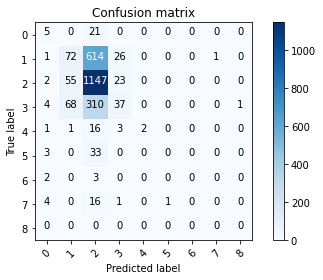

In [87]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred, labels=[0,1,2,3,4,5,6,7,8])

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1,2,3,4,5,6,7,8],
                      title='Confusion matrix')

## Random Forest

In [88]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [89]:
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5406389001213101


Confusion matrix, without normalization
[[ 15   0   0   0   1  10   0   0   0]
 [  1 221 436  49   4   1   0   2   0]
 [  0 177 998  48   3   1   0   0   0]
 [  1 123 210  82   2   0   0   2   0]
 [  2   4   5   2   9   0   0   1   0]
 [  9   5  10   1   1  10   0   0   0]
 [  0   1   1   0   1   0   0   2   0]
 [  3   3   4   5   5   0   0   2   0]
 [  0   0   0   0   0   0   0   0   0]]


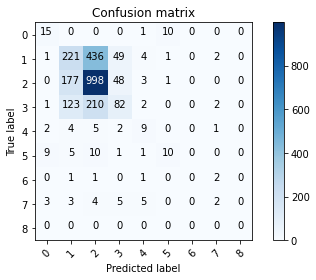

In [90]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred, labels=[0,1,2,3,4,5,6,7,8])

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1,2,3,4,5,6,7,8],
                      title='Confusion matrix')

## lgbm

In [99]:
# format data for lgbm
train_data = lgb.Dataset(X_train, label=y_train)

# model parameters (needs tuning)
parameters = {
    'objective': 'multiclass',
    'num_class': 9,
    'metric': 'multi_logloss',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'boost_from_average': True,
    'verbose': 0,
    'seed': 100
}

In [100]:
clf = lgb.train(parameters, train_data)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

In [106]:
y_pred = clf.predict(X_test)
# get max probability for each prediction
y_pred = [np.argmax(line) for line in y_pred]
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5402345329559239
